In [1]:
import numpy
import pandas
import seaborn
import logging
import time
import collections
import os
from os import environ
from matplotlib import pyplot

import sklearn
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.linear_model

%matplotlib inline
logging.basicConfig(level="DEBUG")
pandas.set_option('display.max_columns', 60)

from copy import deepcopy
import shutil
import bz2

import tensorflow as tf

def ppv(y_true, predictions):
    df = pandas.DataFrame({"prediction": predictions, "y_true": y_true})
    return df.sort_values("prediction", ascending=False)[:int(y_true.sum())].y_true.mean()

import logomaker

import traceback
import json
from scipy.stats import pearsonr

import tqdm

from notebook.services.config import ConfigManager
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})

import mhcgnomes

import mhc2flurry
from mhc2flurry.downloads import get_path
import mhc2flurry.allele_encoding_pair
import mhc2flurry.allele_encoding
import mhc2flurry.fasta
import mhc2flurry.common

from mhcflurry.regression_target import from_ic50, to_ic50

import tensorflow as tf ; print("GPU AVAILABLE" if tf.test.is_gpu_available() else "GPU NOT AVAILABLE")

DEBUG:root:Configured MHC2FLURRY_DOWNLOADS_DIR: /hpc/users/odonnt02/.local/share/mhc2flurry/1/0.0.1
DEBUG:tensorflow:Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
DEBUG:root:Configured MHCFLURRY_DOWNLOADS_DIR: /hpc/users/odonnt02/.local/share/mhcflurry/4/2.0.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


GPU AVAILABLE


In [2]:
!ls "$(mhc2flurry-downloads path data_curated)"

annotate_proteins.py				DOWNLOAD_INFO.csv
curated_training_data.affinity.csv.bz2		expression
curated_training_data.csv.bz2			GENERATE.sh
curated_training_data.mass_spec.csv.bz2		LOG.txt.bz2
curated_training_data.no_additional_ms.csv.bz2	ms.by_pmid.csv.bz2
curate_ms_by_pmid.py				rna_expression.csv.bz2
curate.py					rna_expression.metadata.csv.bz2


In [3]:
!cat "$(mhc2flurry-downloads path data_curated)/DOWNLOAD_INFO.csv"

url
https://github.com/openvax/mhc2flurry/releases/download/pre-0.0.1/data_curated.20210309.tar.bz2


In [4]:
!mhc2flurry-downloads info

Environment variables
  MHC2FLURRY_DATA_DIR                 [unset or empty]
  MHC2FLURRY_DOWNLOADS_CURRENT_RELEASE [unset or empty]
  MHC2FLURRY_DOWNLOADS_DIR            [unset or empty]
  MHC2FLURRY_DEFAULT_MODELS_DIR       [unset or empty]
  MHC2FLURRY_DOWNLOADS_GITHUB_AUTH_TOKEN = 854f2d6a1a86e618a85e5a357243a410b4016125

Configuration
  current release                     = 0.0.1                
  downloads dir                       = /hpc/users/odonnt02/.local/share/mhc2flurry/1/0.0.1 [exists]

DOWNLOAD NAME                             DOWNLOADED?   UP TO DATE?   URL                  
allele_sequences                          YES           YES           https://github.com/openvax/mhc2flurry/releases/download/pre-0.0.1/allele_sequences.20210222.tar.bz2 
data_curated                              YES           YES           https://github.com/openvax/mhc2flurry/releases/download/pre-0.0.1/data_curated.20210309.tar.bz2 
data_published                            NO                    

In [5]:
protein_column_converters = {}
for col in ["proteins_human", "proteins_mouse", "proteins_viral"]:
    protein_column_converters[col] = str.split


In [6]:
curated_df = pandas.read_csv(
    get_path("data_curated", "curated_training_data.csv.bz2"),
    converters=protein_column_converters)
curated_df

,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_kind,measurement_source,original_allele,proteins_human,proteins_mouse,proteins_viral
0,BoLA-DRB3*001:01,AYAAQGYKVLVLNPSVAA,1541.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,[],[],"[sp|O92972|POLG_HCVJ4, sp|O92532|POLG_HCVVP, s..."
1,BoLA-DRB3*001:01,CGKYLFNWAVRTKLKLTPIA,8776.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,[],[],"[sp|Q03463|POLG_HCVJ1, sp|P26664|POLG_HCV1]"
2,BoLA-DRB3*001:01,ENLPYLVAYQATVCARAQAP,36805.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,[],[],[sp|P26664|POLG_HCV1]
3,BoLA-DRB3*001:01,GIQYLAGLSTLPGNPAIASL,100000.0,>,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,[],[],"[sp|O92972|POLG_HCVJ4, sp|O92532|POLG_HCVVP, s..."
4,BoLA-DRB3*001:01,KGGRKPARLIVFPDLGVRVC,3336.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,[],[],"[sp|O92972|POLG_HCVJ4, sp|Q9WMX2|POLG_HCVCO, s..."
...,...,...,...,...,...,...,...,...,...,...,...
311559,SLA-DRB1*10:01,THVLTNLPL,100.0,<,qualitative,affinity,Meng - cellular MHC/direct/fluorescence,SLA-DRB1*10:01,[],[],[]
311560,SLA-DRB1*10:01,VSHLPVFFSHLFKSDSGYS,100.0,<,qualitative,affinity,Meng - cellular MHC/direct/fluorescence,SLA-DRB1*10:01,[],[],[]
311561,SLA-DRB1*10:01,WGFAAFTLF,100.0,<,qualitative,affinity,Meng - cellular MHC/direct/fluorescence,SLA-DRB1*10:01,[],[],[]
311562,SLA-DRB1*10:01,YEASPLAPL,100.0,<,qualitative,affinity,Meng - cellular MHC/direct/fluorescence,SLA-DRB1*10:01,[],[],[]


In [7]:
curated_df.measurement_type.value_counts()
curated_df.measurement_source.value_counts()
curated_df.measurement_kind.value_counts()
curated_df.loc[curated_df.measurement_kind == "mass_spec"].measurement_source.value_counts()


Falkenburg - cellular MHC/mass spectrometry             81031
Neidert - cellular MHC/mass spectrometry                45387
MS:pmid:31495665                                        43332
Sollid - cellular MHC/mass spectrometry                 18926
Alizadeh - cellular MHC/mass spectrometry                4058
                                                        ...  
Urbaniak - secreted MHC/mass spectrometry                   4
Hill - cellular MHC/mass spectrometry                       4
Poland - secreted MHC/mass spectrometry                     2
LeibundGut-Landmann - secreted MHC/mass spectrometry        2
Purcell - cellular MHC/mass spectrometry                    1
Name: measurement_source, Length: 61, dtype: int64

In [8]:
curated_df.loc[curated_df.measurement_source.str.startswith("MS:pmid")].measurement_source.value_counts()

MS:pmid:31495665    43332
Name: measurement_source, dtype: int64

In [9]:
curated_df.loc[curated_df.measurement_kind == "mass_spec"].measurement_inequality.value_counts()

<    211651
Name: measurement_inequality, dtype: int64

In [10]:
ms_df = pandas.read_csv(
    get_path("data_curated", "ms.by_pmid.csv.bz2"),
    converters=protein_column_converters)
ms_df = ms_df.loc[
    ms_df.mhc_class == "II"
]
ms_df["hla"] = ms_df.hla.str.split().map(tuple)
ms_df["allele_pairs"] = ms_df.hla.map(mhc2flurry.common.make_allele_pairs).map(tuple)
ms_df

,pmid,sample_id,peptide,format,mhc_class,hla,expression_dataset,cell_line,original_pmid,pulldown_antibody,sample_type,proteins_human,proteins_mouse,proteins_viral,allele_pairs
0,29314611,MAVER-1_DR,TPEQWKSHKSYSCQVTHEGSTVEK,DR-SPECIFIC,II,"(HLA-DRB1*01:01, HLA-DRB1*13:01, HLA-DRB3*02:0...",sample_type:B-CELL,MAVER-1,29314611,L243 (HLA-DR),B-CELL,[],[],[],"(HLA-DRA*01:01-DRB1*01:01, HLA-DRA*01:01-DRB1*..."
1,29314611,MAVER-1_DR,KPISKAVIVLNEGIKVQTKE,DR-SPECIFIC,II,"(HLA-DRB1*01:01, HLA-DRB1*13:01, HLA-DRB3*02:0...",sample_type:B-CELL,MAVER-1,29314611,L243 (HLA-DR),B-CELL,[sp|O75976-2|CBPD-2_HUMAN],[],[],"(HLA-DRA*01:01-DRB1*01:01, HLA-DRA*01:01-DRB1*..."
2,29314611,MAVER-1_DR,DPSAVAKHFVALSTNTTKVKE,DR-SPECIFIC,II,"(HLA-DRB1*01:01, HLA-DRB1*13:01, HLA-DRB3*02:0...",sample_type:B-CELL,MAVER-1,29314611,L243 (HLA-DR),B-CELL,"[tr|A0A2R8Y6C7|A0A2R8Y6C7_HUMAN, sp|P06744-2|G...",[],[],"(HLA-DRA*01:01-DRB1*01:01, HLA-DRA*01:01-DRB1*..."
3,29314611,MAVER-1_DR,VSKALHKAALTIDEKGTEAVGSTFLE,DR-SPECIFIC,II,"(HLA-DRB1*01:01, HLA-DRB1*13:01, HLA-DRB3*02:0...",sample_type:B-CELL,MAVER-1,29314611,L243 (HLA-DR),B-CELL,[],[],[],"(HLA-DRA*01:01-DRB1*01:01, HLA-DRA*01:01-DRB1*..."
4,29314611,MAVER-1_DR,TPEQWKSHKSYSCQVTHEGSTVEKTVAPTE,DR-SPECIFIC,II,"(HLA-DRB1*01:01, HLA-DRB1*13:01, HLA-DRB3*02:0...",sample_type:B-CELL,MAVER-1,29314611,L243 (HLA-DR),B-CELL,[],[],[],"(HLA-DRA*01:01-DRB1*01:01, HLA-DRA*01:01-DRB1*..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337967,31611696,3912_BAM-HLA-DR-DEPLETED,YYYIQQDTKGDYQKA,DR-DEPLETED,II,"(HLA-DRB1*03:01, HLA-DRB1*04:01, HLA-DRB3*01:0...",sample_type:MENINGIOMA,NaN,31611696,NaN,MENINGIOMA,[sp|P07355-2|ANXA2-2_HUMAN],[tr|B0V2N5|B0V2N5_MOUSE],[],"(HLA-DRA*01:01-DRB1*03:01, HLA-DRA*01:01-DRB1*..."
337968,31611696,4052_BA-HLA-DR,YYYIQQDTKGDYQKA,DR-SPECIFIC,II,"(HLA-DRB1*03:01, HLA-DRB1*11:04, HLA-DRB3*01:0...",sample_type:MENINGIOMA,NaN,31611696,HB298,MENINGIOMA,[sp|P07355-2|ANXA2-2_HUMAN],[tr|B0V2N5|B0V2N5_MOUSE],[],"(HLA-DRA*01:01-DRB1*03:01, HLA-DRA*01:01-DRB1*..."
337969,31611696,4052_BA-HLA-DR-DEPLETED,YYYIQQDTKGDYQKA,DR-DEPLETED,II,"(HLA-DRB1*03:01, HLA-DRB1*11:04, HLA-DRB3*01:0...",sample_type:MENINGIOMA,NaN,31611696,NaN,MENINGIOMA,[sp|P07355-2|ANXA2-2_HUMAN],[tr|B0V2N5|B0V2N5_MOUSE],[],"(HLA-DRA*01:01-DRB1*03:01, HLA-DRA*01:01-DRB1*..."
337970,31611696,3912_BAM-HLA-DR,YYYIQQDTKGDYQKAL,DR-SPECIFIC,II,"(HLA-DRB1*03:01, HLA-DRB1*04:01, HLA-DRB3*01:0...",sample_type:MENINGIOMA,NaN,31611696,HB298,MENINGIOMA,[sp|P07355-2|ANXA2-2_HUMAN],[tr|B0V2N5|B0V2N5_MOUSE],[],"(HLA-DRA*01:01-DRB1*03:01, HLA-DRA*01:01-DRB1*..."


In [11]:
# TODO: how to make pairs from e.g. HLA-DPA1*01:03, HLA-DPB1*04:01 ? Need to take all combinations?

In [12]:
ms_df.original_pmid.value_counts()

31611696    243301
31495665     66607
29314611     28064
Name: original_pmid, dtype: int64

In [13]:
ms_df.proteins_human.isnull().mean()

0.0

In [14]:
usable_ms_df = ms_df.loc[ms_df.proteins_human.str.len() > 0]
len(usable_ms_df)

256434

In [15]:
# Train on monoallelic, validate on multiallelic
train_df = usable_ms_df.loc[usable_ms_df.format == "MONOALLELIC"].copy()
assert (train_df.allele_pairs.str.len() == 1).all()
train_df["allele"] = train_df.allele_pairs.str.get(0)
train_df["parsed_allele"] = train_df.allele.map(lambda s: mhcgnomes.parse(s, infer_class2_pairing=True))

print(len(train_df))
print(train_df.pmid.value_counts())
train_df.allele.value_counts()

33806
31495665    33806
Name: pmid, dtype: int64


HLA-DRA*01:01-DRB1*11:01     7085
HLA-DRA*01:01-DRB1*01:01     6036
HLA-DRA*01:01-DRB1*07:01     4329
HLA-DPA1*01:03-DPB1*06:01    4319
HLA-DRA*01:01-DRB1*15:01     2677
HLA-DRA*01:01-DRB1*03:01     1948
HLA-DRA*01:01-DRB1*04:01     1925
HLA-DRA*01:01-DRB3*01:01     1886
HLA-DRA*01:01-DRB1*12:01     1842
HLA-DQA1*01:02-DQB1*06:04    1759
Name: allele, dtype: int64

In [16]:
validation_df = usable_ms_df.loc[~usable_ms_df.peptide.isin(train_df.peptide)]
print(len(validation_df))
print(validation_df.pmid.value_counts())
validation_df.allele_pairs.value_counts()

192862
31611696    165262
29314611     14891
31495665     12709
Name: pmid, dtype: int64


(HLA-DRA*01:01-DRB1*11:01, HLA-DRA*01:01-DRB3*02:02, HLA-DPA1*01:03-DPB1*04:01, HLA-DPA1*01:03-DPB1*04:02, HLA-DQA1*05:05-DQB1*03:01)                                                                                                                                                                                               17213
(HLA-DRA*01:01-DRB1*04:01, HLA-DRA*01:01-DRB1*08:01, HLA-DRA*01:01-DRB4*01:03, HLA-DPA1*01:03-DPB1*04:01, HLA-DPA1*01:03-DPB1*04:02, HLA-DQA1*03:03-DQB1*03:01, HLA-DQA1*03:03-DQB1*04:02, HLA-DQA1*04:01-DQB1*03:01, HLA-DQA1*04:01-DQB1*04:02)                                                                                    13234
(HLA-DRA*01:01-DRB1*07:01, HLA-DRA*01:01-DRB1*16:01, HLA-DRA*01:01-DRB4*01:03, HLA-DRA*01:01-DRB5*02:02, HLA-DPA1*01:03-DPB1*02:01, HLA-DPA1*01:03-DPB1*23:01, HLA-DQA1*01:02-DQB1*02:02, HLA-DQA1*01:02-DQB1*05:02, HLA-DQA1*02:01-DQB1*02:02, HLA-DQA1*02:01-DQB1*05:02)                                                          10605
(HLA-DRA*0

In [17]:
proteins_df = mhc2flurry.fasta.read_fasta_to_dataframe(
    get_path("data_proteomes", "human.uniprot.isoforms.fasta.gz")).set_index("sequence_id")
proteins_df

,sequence
sequence_id,
tr|A0A3F2YPB8|A0A3F2YPB8_HUMAN,MAATDLSYGLYRDPVCLQEKTEVERVVADCLTNCYQDSVTFDDLAV...
tr|A6NDF3|A6NDF3_HUMAN,MAATSGTDEPVSGELVSVAHALSLPAESYGNDPDIEMAWAMRAMQH...
tr|A6NDI8|A6NDI8_HUMAN,MTSTGQDSTTTRQRRSRQNPQSPPQDSSVTSKRNIKKGAVPRSIPN...
tr|A6NDJ3|A6NDJ3_HUMAN,MRPEGSLTYWVPERLRQGFCGVGRAAQALVELEPVNAQARKAFSRQ...
tr|A8MVT4|A8MVT4_HUMAN,MARNVVYPLYRLGGPQLRVFRTNFFIQLVRPGVAQPEDTVQFRIPM...
...,...
tr|U3KQA8|U3KQA8_HUMAN,MGTSSIFLCVLFLCGALGLTMSPARGRLRCYICGFTKPCHPVPTEC...
tr|U3KQK5|U3KQK5_HUMAN,MSVLTPLLLRGLTGSARRLPVPRAKIHSLPPEGKLGIMGKENGIGS...
tr|V9GXZ4|V9GXZ4_HUMAN,MRAVRRGLREGGAMAAARDPPEVSLREATQRKLRRFSELRGKLVAR...


In [18]:
# Need to match lengths of hits and decoys. I do not expect there is important information we want to learn in
# the hit lengths.

import random

def add_decoys(hits_df, protein_to_sequence, protein_column="proteins_human", decoys_per_hit=10):
    """
    protein_to_sequence : dict like, str -> str
        Map from protein names to full amino acid sequences
        
    protein_sequences_df : pandas.DataFrame
        Should have columns: peptide, and the column specified in protein_column.
        All other columns will be copied 
    """
    hits_df = hits_df.loc[hits_df[protein_column].str.len() > 0].copy()
    hits_df["protein"] = hits_df[protein_column].str.get(0) # For now just taking first. Later can use expression info.
    hits_df["hit"] = 1
    hits_df["peptide_length"] = hits_df.peptide.str.len()

    # List of lists. Total number of lists is decoys_per_hit (e.g. 100).
    # The i'th decoy peptide in each list is generated based on the 
    # i'th hit peptide.
    decoy_peptides = [[] for _ in range(decoys_per_hit)]
    
    for protein, peptide_length in tqdm.tqdm(hits_df[["protein", "peptide_length"]].itertuples(index=False), total=len(hits_df)):
        sequence = protein_to_sequence[protein]
        for decoy_set in decoy_peptides:
            start = random.randrange(0, len(sequence) - peptide_length + 1)
            decoy_set.append(sequence[start : start + peptide_length])
        
    decoy_dfs = []
    for i in tqdm.tqdm(range(decoys_per_hit), total=decoys_per_hit):
        df = hits_df.copy()
        df["hit"] = 0
        df["peptide"] = decoy_peptides.pop(0)
        decoy_dfs.append(df)  
        
    result_df = pandas.concat([hits_df] + decoy_dfs, ignore_index=True)
    return result_df


validation_with_decoys_df = add_decoys(
    validation_df,
    proteins_df.sequence.to_dict(),
    protein_column="proteins_human",
    decoys_per_hit=1)
validation_with_decoys_df

100%|██████████| 1/1 [00:00<00:00, 25.97it/s]


,pmid,sample_id,peptide,format,mhc_class,hla,expression_dataset,cell_line,original_pmid,pulldown_antibody,sample_type,proteins_human,proteins_mouse,proteins_viral,allele_pairs,protein,hit,peptide_length
0,29314611,MAVER-1_DR,KPISKAVIVLNEGIKVQTKE,DR-SPECIFIC,II,"(HLA-DRB1*01:01, HLA-DRB1*13:01, HLA-DRB3*02:0...",sample_type:B-CELL,MAVER-1,29314611,L243 (HLA-DR),B-CELL,[sp|O75976-2|CBPD-2_HUMAN],[],[],"(HLA-DRA*01:01-DRB1*01:01, HLA-DRA*01:01-DRB1*...",sp|O75976-2|CBPD-2_HUMAN,1,20
1,29314611,MAVER-1_DR,DPSAVAKHFVALSTNTTKVKE,DR-SPECIFIC,II,"(HLA-DRB1*01:01, HLA-DRB1*13:01, HLA-DRB3*02:0...",sample_type:B-CELL,MAVER-1,29314611,L243 (HLA-DR),B-CELL,"[tr|A0A2R8Y6C7|A0A2R8Y6C7_HUMAN, sp|P06744-2|G...",[],[],"(HLA-DRA*01:01-DRB1*01:01, HLA-DRA*01:01-DRB1*...",tr|A0A2R8Y6C7|A0A2R8Y6C7_HUMAN,1,21
2,29314611,MAVER-1_DR,TPAKPSSPPPEFSFNTPGKNVN,DR-SPECIFIC,II,"(HLA-DRB1*01:01, HLA-DRB1*13:01, HLA-DRB3*02:0...",sample_type:B-CELL,MAVER-1,29314611,L243 (HLA-DR),B-CELL,"[sp|Q6NXT4-2|ZNT6-2_HUMAN, sp|Q6NXT4-3|ZNT6-3_...",[],[],"(HLA-DRA*01:01-DRB1*01:01, HLA-DRA*01:01-DRB1*...",sp|Q6NXT4-2|ZNT6-2_HUMAN,1,22
3,29314611,MAVER-1_DR,REIDDHDAVLRFNGAPTANFQQDVGTK,DR-SPECIFIC,II,"(HLA-DRB1*01:01, HLA-DRB1*13:01, HLA-DRB3*02:0...",sample_type:B-CELL,MAVER-1,29314611,L243 (HLA-DR),B-CELL,[tr|H7C472|H7C472_HUMAN],[],[],"(HLA-DRA*01:01-DRB1*01:01, HLA-DRA*01:01-DRB1*...",tr|H7C472|H7C472_HUMAN,1,27
4,29314611,MAVER-1_DR,RPGGVVHSFSHNVGPGDK,DR-SPECIFIC,II,"(HLA-DRB1*01:01, HLA-DRB1*13:01, HLA-DRB3*02:0...",sample_type:B-CELL,MAVER-1,29314611,L243 (HLA-DR),B-CELL,[tr|M0QYN0|M0QYN0_HUMAN],[],[],"(HLA-DRA*01:01-DRB1*01:01, HLA-DRA*01:01-DRB1*...",tr|M0QYN0|M0QYN0_HUMAN,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385719,31611696,3912_BAM-HLA-DR-DEPLETED,KVLIRIMVSRSEVDM,DR-DEPLETED,II,"(HLA-DRB1*03:01, HLA-DRB1*04:01, HLA-DRB3*01:0...",sample_type:MENINGIOMA,NaN,31611696,NaN,MENINGIOMA,[sp|P07355-2|ANXA2-2_HUMAN],[tr|B0V2N5|B0V2N5_MOUSE],[],"(HLA-DRA*01:01-DRB1*03:01, HLA-DRA*01:01-DRB1*...",sp|P07355-2|ANXA2-2_HUMAN,0,15
385720,31611696,4052_BA-HLA-DR,SLEGDHSTPPSAYGS,DR-SPECIFIC,II,"(HLA-DRB1*03:01, HLA-DRB1*11:04, HLA-DRB3*01:0...",sample_type:MENINGIOMA,NaN,31611696,HB298,MENINGIOMA,[sp|P07355-2|ANXA2-2_HUMAN],[tr|B0V2N5|B0V2N5_MOUSE],[],"(HLA-DRA*01:01-DRB1*03:01, HLA-DRA*01:01-DRB1*...",sp|P07355-2|ANXA2-2_HUMAN,0,15
385721,31611696,4052_BA-HLA-DR-DEPLETED,VPKWISIMTERSVPH,DR-DEPLETED,II,"(HLA-DRB1*03:01, HLA-DRB1*11:04, HLA-DRB3*01:0...",sample_type:MENINGIOMA,NaN,31611696,NaN,MENINGIOMA,[sp|P07355-2|ANXA2-2_HUMAN],[tr|B0V2N5|B0V2N5_MOUSE],[],"(HLA-DRA*01:01-DRB1*03:01, HLA-DRA*01:01-DRB1*...",sp|P07355-2|ANXA2-2_HUMAN,0,15
385722,31611696,3912_BAM-HLA-DR,SDTSGDFRKLMVALAK,DR-SPECIFIC,II,"(HLA-DRB1*03:01, HLA-DRB1*04:01, HLA-DRB3*01:0...",sample_type:MENINGIOMA,NaN,31611696,HB298,MENINGIOMA,[sp|P07355-2|ANXA2-2_HUMAN],[tr|B0V2N5|B0V2N5_MOUSE],[],"(HLA-DRA*01:01-DRB1*03:01, HLA-DRA*01:01-DRB1*...",sp|P07355-2|ANXA2-2_HUMAN,0,16


In [19]:
train_with_decoys_df = add_decoys(
    train_df,
    proteins_df.sequence.to_dict(),
    protein_column="proteins_human",
    decoys_per_hit=1)
train_with_decoys_df

100%|██████████| 1/1 [00:00<00:00, 157.18it/s]


,pmid,sample_id,peptide,format,mhc_class,hla,expression_dataset,cell_line,original_pmid,pulldown_antibody,sample_type,proteins_human,proteins_mouse,proteins_viral,allele_pairs,allele,parsed_allele,protein,hit,peptide_length
0,31495665,MAPTAC_DRB1*12:01_DM-,VPGPGPAPMPSDFQVLRAKY,MONOALLELIC,II,"(HLA-DRB1*12:01,)",cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,[sp|O95479-2|G6PE-2_HUMAN],[],[],"(HLA-DRA*01:01-DRB1*12:01,)",HLA-DRA*01:01-DRB1*12:01,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,sp|O95479-2|G6PE-2_HUMAN,1,20
1,31495665,MAPTAC_DRB1*12:01_DM-,ALMGYATHKYLDSEEDEE,MONOALLELIC,II,"(HLA-DRB1*12:01,)",cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,"[sp|P09912-2|IFI6-2_HUMAN, sp|P09912-3|IFI6-3_...",[],[],"(HLA-DRA*01:01-DRB1*12:01,)",HLA-DRA*01:01-DRB1*12:01,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,sp|P09912-2|IFI6-2_HUMAN,1,18
2,31495665,MAPTAC_DRB1*12:01_DM-,GSDQSENVDRGAGSIREA,MONOALLELIC,II,"(HLA-DRB1*12:01,)",cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,"[sp|Q9UII2-2|ATIF1-2_HUMAN, sp|Q9UII2-3|ATIF1-...",[],[],"(HLA-DRA*01:01-DRB1*12:01,)",HLA-DRA*01:01-DRB1*12:01,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,sp|Q9UII2-2|ATIF1-2_HUMAN,1,18
3,31495665,MAPTAC_DRB1*12:01_DM-,FNYRRRRPENPKPQDGKETKAAD,MONOALLELIC,II,"(HLA-DRB1*12:01,)",cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,[tr|H0Y449|H0Y449_HUMAN],[tr|A2BGG7|A2BGG7_MOUSE],[],"(HLA-DRA*01:01-DRB1*12:01,)",HLA-DRA*01:01-DRB1*12:01,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,tr|H0Y449|H0Y449_HUMAN,1,23
4,31495665,MAPTAC_DRB1*12:01_DM-,FNYRRRRPENPKPQDGKETKAADPPAE,MONOALLELIC,II,"(HLA-DRB1*12:01,)",cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,[tr|H0Y449|H0Y449_HUMAN],[tr|A2BGG7|A2BGG7_MOUSE],[],"(HLA-DRA*01:01-DRB1*12:01,)",HLA-DRA*01:01-DRB1*12:01,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,tr|H0Y449|H0Y449_HUMAN,1,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67607,31495665,MAPTAC_DRB1*15:01,SGLNSEKVAA,MONOALLELIC,II,"(HLA-DRB1*15:01,)",cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,"[tr|J3KS79|J3KS79_HUMAN, tr|K7ENH5|K7ENH5_HUMA...","[tr|E9PZH4|E9PZH4_MOUSE, tr|E9Q6V3|E9Q6V3_MOUSE]",[],"(HLA-DRA*01:01-DRB1*15:01,)",HLA-DRA*01:01-DRB1*15:01,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,tr|J3KS79|J3KS79_HUMAN,0,10
67608,31495665,MAPTAC_DRB1*15:01,QGSEACTCDSGDYKLSLAG,MONOALLELIC,II,"(HLA-DRB1*15:01,)",cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,[sp|Q8IWU5-2|SULF2-2_HUMAN],[],[],"(HLA-DRA*01:01-DRB1*15:01,)",HLA-DRA*01:01-DRB1*15:01,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,sp|Q8IWU5-2|SULF2-2_HUMAN,0,19
67609,31495665,MAPTAC_DRB1*15:01,GSITSAKVMLEDGRSKG,MONOALLELIC,II,"(HLA-DRB1*15:01,)",cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,"[tr|H0YEU6|H0YEU6_HUMAN, tr|H0Y5F5|H0Y5F5_HUMA...","[tr|A3KFU5|A3KFU5_MOUSE, tr|A3KFU8|A3KFU8_MOUS...",[],"(HLA-DRA*01:01-DRB1*15:01,)",HLA-DRA*01:01-DRB1*15:01,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,tr|H0YEU6|H0YEU6_HUMAN,0,17
67610,31495665,MAPTAC_DRB1*15:01,QAMFRIRILEQRLNRH,MONOALLELIC,II,"(HLA-DRB1*15:01,)",cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,"[sp|Q8IY82-2|DRC7-2_HUMAN, tr|H3BRR8|H3BRR8_HU...",[],[],"(HLA-DRA*01:01-DRB1*15:01,)",HLA-DRA*01:01-DRB1*15:01,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,sp|Q8IY82-2|DRC7-2_HUMAN,0,16


In [20]:
assert (train_with_decoys_df.allele_pairs.str.len() == 1).all()
train_with_decoys_df.allele.value_counts()


HLA-DRA*01:01-DRB1*11:01     14170
HLA-DRA*01:01-DRB1*01:01     12072
HLA-DRA*01:01-DRB1*07:01      8658
HLA-DPA1*01:03-DPB1*06:01     8638
HLA-DRA*01:01-DRB1*15:01      5354
HLA-DRA*01:01-DRB1*03:01      3896
HLA-DRA*01:01-DRB1*04:01      3850
HLA-DRA*01:01-DRB3*01:01      3772
HLA-DRA*01:01-DRB1*12:01      3684
HLA-DQA1*01:02-DQB1*06:04     3518
Name: allele, dtype: int64

In [21]:
allele_sequences_df = pandas.read_csv(get_path("allele_sequences", "allele_sequences.csv"), index_col=0)
allele_sequences_variant = allele_sequences_df.columns[0]
print("using variant", allele_sequences_variant)
allele_sequences_alpha = allele_sequences_df.loc[allele_sequences_df.kind == "alpha", allele_sequences_variant]
allele_sequences_beta = allele_sequences_df.loc[allele_sequences_df.kind == "beta", allele_sequences_variant]
allele_sequences_alpha, allele_sequences_beta

using variant maf_0.2_and_0.3_within_6.0_angstrom


(sequence_id
 HLA-DPA1*02:38Q    SYMFFQRAFSEGGAIILNTL
 HLA-DPA1*01:03     SYAFFMQAFSEGGAIILNTL
 HLA-DPA1*01:03Q    SYAFFMQAFSEGGAIILNTL
 HLA-DPA1*01:14     SYAFFMQAFSEGGAIILNTL
 HLA-DPA1*01:18     SYAFFMQAFSEGGAIILNTL
                            ...         
 HLA-DPA1*01:46     SYAFFMQAFSEGGAIILNTL
 HLA-DPA1*01:05     SYAFFMQAFSEGGAIILNTL
 HLA-DPA1*01:41     SYAFFMQAFSEGGAIILNTL
 HLA-DPA1*02:03     SYAFFMRAFSEGGAIILNTL
 HLA-DPA1*02:16     SYAFFQRAFSEGGAIILNTL
 Name: maf_0.2_and_0.3_within_6.0_angstrom, Length: 174, dtype: object,
 sequence_id
 HLA-DQB1*05:03      YFGGTHYVYDVGASRVEVAYGI
 HLA-DQB1*05:08      YFGGTHYVYDVGASRVEVAYGI
 HLA-DQB1*05:10      YFGGTHYVYDVGASRVEVAYGI
 HLA-DQB1*05:108     YFGGTHYVYDVGASRVEVAYGI
 HLA-DQB1*05:134     YFGGTHYVYDVGASRVEVAYGI
                              ...          
 HLA-DQB1*03:422N    YFGLTYYAYAVRTETVQLELTT
 HLA-DRB1*12:06      ESGLEHLLFVIDRATYGAVEFT
 HLA-DRB4*01:124     EACNIYYAYDLRRETYGVVEFT
 HLA-DRB5*01:08N     QDYFHGNVYDFDRATYGVGEFT
 HLA-DQB1*0

In [22]:
from mhc2flurry.amino_acid import COMMON_AMINO_ACIDS
COMMON_AMINO_ACIDS

aa_regex = "^[%s]+$" % "".join(sorted(COMMON_AMINO_ACIDS))
aa_regex
train_with_decoys_df.peptide.str.match(aa_regex).mean()

0.9998373069869254

In [23]:
use_train_df = train_with_decoys_df.loc[
    train_with_decoys_df.parsed_allele.map(
        lambda p: isinstance(p, mhcgnomes.Class2Pair))
].copy()
print("Excluding", train_with_decoys_df.loc[~train_with_decoys_df.index.isin(use_train_df.index)].allele.unique())

use_train_df = use_train_df.loc[use_train_df.peptide.str.match(aa_regex)]

use_train_df["alpha_allele"] = train_with_decoys_df.parsed_allele.map(lambda p: p.alpha.to_string())
use_train_df["beta_allele"] = train_with_decoys_df.parsed_allele.map(lambda p: p.beta.to_string())

use_train_df = use_train_df.loc[
    (use_train_df.alpha_allele.isin(allele_sequences_alpha.index)) &
    (use_train_df.beta_allele.isin(allele_sequences_beta.index))
].copy()

use_train_df

Excluding []


,pmid,sample_id,peptide,format,mhc_class,hla,expression_dataset,cell_line,original_pmid,pulldown_antibody,sample_type,proteins_human,proteins_mouse,proteins_viral,allele_pairs,allele,parsed_allele,protein,hit,peptide_length,alpha_allele,beta_allele
0,31495665,MAPTAC_DRB1*12:01_DM-,VPGPGPAPMPSDFQVLRAKY,MONOALLELIC,II,"(HLA-DRB1*12:01,)",cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,[sp|O95479-2|G6PE-2_HUMAN],[],[],"(HLA-DRA*01:01-DRB1*12:01,)",HLA-DRA*01:01-DRB1*12:01,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,sp|O95479-2|G6PE-2_HUMAN,1,20,HLA-DRA*01:01,HLA-DRB1*12:01
1,31495665,MAPTAC_DRB1*12:01_DM-,ALMGYATHKYLDSEEDEE,MONOALLELIC,II,"(HLA-DRB1*12:01,)",cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,"[sp|P09912-2|IFI6-2_HUMAN, sp|P09912-3|IFI6-3_...",[],[],"(HLA-DRA*01:01-DRB1*12:01,)",HLA-DRA*01:01-DRB1*12:01,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,sp|P09912-2|IFI6-2_HUMAN,1,18,HLA-DRA*01:01,HLA-DRB1*12:01
2,31495665,MAPTAC_DRB1*12:01_DM-,GSDQSENVDRGAGSIREA,MONOALLELIC,II,"(HLA-DRB1*12:01,)",cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,"[sp|Q9UII2-2|ATIF1-2_HUMAN, sp|Q9UII2-3|ATIF1-...",[],[],"(HLA-DRA*01:01-DRB1*12:01,)",HLA-DRA*01:01-DRB1*12:01,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,sp|Q9UII2-2|ATIF1-2_HUMAN,1,18,HLA-DRA*01:01,HLA-DRB1*12:01
3,31495665,MAPTAC_DRB1*12:01_DM-,FNYRRRRPENPKPQDGKETKAAD,MONOALLELIC,II,"(HLA-DRB1*12:01,)",cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,[tr|H0Y449|H0Y449_HUMAN],[tr|A2BGG7|A2BGG7_MOUSE],[],"(HLA-DRA*01:01-DRB1*12:01,)",HLA-DRA*01:01-DRB1*12:01,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,tr|H0Y449|H0Y449_HUMAN,1,23,HLA-DRA*01:01,HLA-DRB1*12:01
4,31495665,MAPTAC_DRB1*12:01_DM-,FNYRRRRPENPKPQDGKETKAADPPAE,MONOALLELIC,II,"(HLA-DRB1*12:01,)",cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,[tr|H0Y449|H0Y449_HUMAN],[tr|A2BGG7|A2BGG7_MOUSE],[],"(HLA-DRA*01:01-DRB1*12:01,)",HLA-DRA*01:01-DRB1*12:01,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,tr|H0Y449|H0Y449_HUMAN,1,27,HLA-DRA*01:01,HLA-DRB1*12:01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67607,31495665,MAPTAC_DRB1*15:01,SGLNSEKVAA,MONOALLELIC,II,"(HLA-DRB1*15:01,)",cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,"[tr|J3KS79|J3KS79_HUMAN, tr|K7ENH5|K7ENH5_HUMA...","[tr|E9PZH4|E9PZH4_MOUSE, tr|E9Q6V3|E9Q6V3_MOUSE]",[],"(HLA-DRA*01:01-DRB1*15:01,)",HLA-DRA*01:01-DRB1*15:01,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,tr|J3KS79|J3KS79_HUMAN,0,10,HLA-DRA*01:01,HLA-DRB1*15:01
67608,31495665,MAPTAC_DRB1*15:01,QGSEACTCDSGDYKLSLAG,MONOALLELIC,II,"(HLA-DRB1*15:01,)",cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,[sp|Q8IWU5-2|SULF2-2_HUMAN],[],[],"(HLA-DRA*01:01-DRB1*15:01,)",HLA-DRA*01:01-DRB1*15:01,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,sp|Q8IWU5-2|SULF2-2_HUMAN,0,19,HLA-DRA*01:01,HLA-DRB1*15:01
67609,31495665,MAPTAC_DRB1*15:01,GSITSAKVMLEDGRSKG,MONOALLELIC,II,"(HLA-DRB1*15:01,)",cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,"[tr|H0YEU6|H0YEU6_HUMAN, tr|H0Y5F5|H0Y5F5_HUMA...","[tr|A3KFU5|A3KFU5_MOUSE, tr|A3KFU8|A3KFU8_MOUS...",[],"(HLA-DRA*01:01-DRB1*15:01,)",HLA-DRA*01:01-DRB1*15:01,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,tr|H0YEU6|H0YEU6_HUMAN,0,17,HLA-DRA*01:01,HLA-DRB1*15:01
67610,31495665,MAPTAC_DRB1*15:01,QAMFRIRILEQRLNRH,MONOALLELIC,II,"(HLA-DRB1*15:01,)",cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,"[sp|Q8IY82-2|DRC7-2_HUMAN, tr|H3BRR8|H3BRR8_HU...",[],[],"(HLA-DRA*01:01-DRB1*15:01,)",HLA-DRA*01:01-DRB1*15:01,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,sp|Q8IY82-2|DRC7-2_HUMAN,0,16,HLA-DRA*01:01,HLA-DRB1*15:01


In [24]:
def flatten_multiallelic(df, hla_column="allele_pairs"):
    result = []
    for allele_pairs, sub_df in tqdm.tqdm(df.groupby("allele_pairs"), total=df[hla_column].nunique()):
        sub_df = sub_df.copy()
        sub_df["original_index"] = sub_df.index
            
        for allele in allele_pairs:
            sub_df = sub_df.copy()
            parsed_allele = mhcgnomes.parse(allele, infer_class2_pairing=True)
            #print(allele, parsed_allele)
            sub_df["allele"] = parsed_allele.to_string()
            sub_df["parsed_allele"] = parsed_allele
            sub_df["alpha_allele"] =  parsed_allele.alpha.to_string()
            sub_df["beta_allele"] =  parsed_allele.beta.to_string()
            result.append(sub_df)
    result = pandas.concat(result, ignore_index=True)
    return result

use_validation_df = flatten_multiallelic(validation_with_decoys_df)

use_validation_df = use_validation_df.loc[
    (use_validation_df.alpha_allele.isin(allele_sequences_alpha.index)) &
    (use_validation_df.beta_allele.isin(allele_sequences_beta.index)) &
    (use_validation_df.peptide.str.match(aa_regex))
].copy()

use_validation_df

100%|██████████| 46/46 [00:01<00:00, 40.46it/s]


,pmid,sample_id,peptide,format,mhc_class,hla,expression_dataset,cell_line,original_pmid,pulldown_antibody,sample_type,proteins_human,proteins_mouse,proteins_viral,allele_pairs,protein,hit,peptide_length,original_index,allele,parsed_allele,alpha_allele,beta_allele
0,31611696,4037-DC,AAEGTWVDMTGARIAYK,MULTIALLELIC,II,"(HLA-DRB1*01:01, HLA-DPA1*01:03, HLA-DPB1*04:0...",sample_type:MENINGIOMA,NaN,31611696,HB145,MENINGIOMA,[tr|E9PHK0|E9PHK0_HUMAN],[],[],"(HLA-DRA*01:01-DRB1*01:01, HLA-DPA1*01:03-DPB1...",tr|E9PHK0|E9PHK0_HUMAN,1,17,27765,HLA-DRA*01:01-DRB1*01:01,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*01:01
1,31611696,4037-DC,AAERKFFLSHPAYR,MULTIALLELIC,II,"(HLA-DRB1*01:01, HLA-DPA1*01:03, HLA-DPB1*04:0...",sample_type:MENINGIOMA,NaN,31611696,HB145,MENINGIOMA,"[tr|K7EMQ3|K7EMQ3_HUMAN, sp|P50570-2|DYN2-2_HU...","[sp|P39054-2|DYN2-2_MOUSE, tr|F8WIV5|F8WIV5_MO...",[],"(HLA-DRA*01:01-DRB1*01:01, HLA-DPA1*01:03-DPB1...",tr|K7EMQ3|K7EMQ3_HUMAN,1,14,27789,HLA-DRA*01:01-DRB1*01:01,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*01:01
2,31611696,4037-DC,AAFAAARSIRARDPG,MULTIALLELIC,II,"(HLA-DRB1*01:01, HLA-DPA1*01:03, HLA-DPB1*04:0...",sample_type:MENINGIOMA,NaN,31611696,HB145,MENINGIOMA,"[tr|A0A6Q8PFM5|A0A6Q8PFM5_HUMAN, tr|A0A6Q8PFE1...","[tr|B1AU25|B1AU25_MOUSE, sp|Q9Z0X1-2|AIFM1-2_M...",[],"(HLA-DRA*01:01-DRB1*01:01, HLA-DPA1*01:03-DPB1...",tr|A0A6Q8PFM5|A0A6Q8PFM5_HUMAN,1,15,27801,HLA-DRA*01:01-DRB1*01:01,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*01:01
3,31611696,4037-DC,AAGAGKVTKSAQKAQKA,MULTIALLELIC,II,"(HLA-DRB1*01:01, HLA-DPA1*01:03, HLA-DPB1*04:0...",sample_type:MENINGIOMA,NaN,31611696,HB145,MENINGIOMA,[tr|A0A087WVQ9|A0A087WVQ9_HUMAN],[],[],"(HLA-DRA*01:01-DRB1*01:01, HLA-DPA1*01:03-DPB1...",tr|A0A087WVQ9|A0A087WVQ9_HUMAN,1,17,27828,HLA-DRA*01:01-DRB1*01:01,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*01:01
4,31611696,4037-DC,AAGAGKVTKSAQKAQKAK,MULTIALLELIC,II,"(HLA-DRB1*01:01, HLA-DPA1*01:03, HLA-DPB1*04:0...",sample_type:MENINGIOMA,NaN,31611696,HB145,MENINGIOMA,[tr|A0A087WVQ9|A0A087WVQ9_HUMAN],[],[],"(HLA-DRA*01:01-DRB1*01:01, HLA-DPA1*01:03-DPB1...",tr|A0A087WVQ9|A0A087WVQ9_HUMAN,1,18,27831,HLA-DRA*01:01-DRB1*01:01,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*01:01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2790263,31611696,3971_ORA-HLA-DR-DEPLETED,KVHGSLARAGKVRGQ,DR-DEPLETED,II,"(HLA-DRB1*13:03, HLA-DRB1*07:01, HLA-DRB3*01:0...",sample_type:MENINGIOMA,NaN,31611696,NaN,MENINGIOMA,"[sp|P62861|RS30_HUMAN, tr|E9PR30|E9PR30_HUMAN,...","[tr|Q642K5|Q642K5_MOUSE, tr|A0A494B9Z0|A0A494B...",[],"(HLA-DRA*01:01-DRB1*13:03, HLA-DRA*01:01-DRB1*...",sp|P62861|RS30_HUMAN,0,15,356328,HLA-DQA1*05:05-DQB1*03:01,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DQA1*05:05,HLA-DQB1*03:01
2790264,31611696,3971_ORA-HLA-DR-DEPLETED,DFKTDLRFQSAAIGAL,DR-DEPLETED,II,"(HLA-DRB1*13:03, HLA-DRB1*07:01, HLA-DRB3*01:0...",sample_type:MENINGIOMA,NaN,31611696,NaN,MENINGIOMA,"[tr|B4DEB1|B4DEB1_HUMAN, tr|A0A590UJJ6|A0A590U...","[tr|A0A1W2P768|A0A1W2P768_MOUSE, tr|F8WI35|F8W...",[],"(HLA-DRA*01:01-DRB1*13:03, HLA-DRA*01:01-DRB1*...",tr|B4DEB1|B4DEB1_HUMAN,0,16,368608,HLA-DQA1*05:05-DQB1*03:01,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DQA1*05:05,HLA-DQB1*03:01
2790265,31611696,3971_ORA-HLA-DR-DEPLETED,RSQEWGREAIEMHENGS,DR-DEPLETED,II,"(HLA-DRB1*13:03, HLA-DRB1*07:01, HLA-DRB3*01:0...",sample_type:MENINGIOMA,NaN,31611696,NaN,MENINGIOMA,"[tr|H7C4K2|H7C4K2_HUMAN, tr|H7C4M4|H7C4M4_HUMAN]",[],[],"(HLA-DRA*01:01-DRB1*13:03, HLA-DRA*01:01-DRB1*...",tr|H7C4K2|H7C4K2_HUMAN,0,17,371775,HLA-DQA1*05:05-DQB1*03:01,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DQA1*05:05,HLA-DQB1*03:01
2790266,31611696,3971_ORA-HLA-DR-DEPLETED,NKSQDSGIAE,DR-DEPLETED,II,"(HLA-DRB1*13:03, HLA-DRB1*07:01, HLA-DRB3*01:0...",sample_type:MENINGIOMA,NaN,31611696,NaN,MENINGIOMA,[sp|Q96

In [25]:
import mhc2flurry.allele_encoding_pair
import mhc2flurry.allele_encoding

train_allele_encoding_pair = mhc2flurry.allele_encoding_pair.AlleleEncodingPair(
    mhc2flurry.allele_encoding.AlleleEncoding(
        use_train_df.alpha_allele.values,
        allele_to_sequence=allele_sequences_alpha.to_dict()),
    mhc2flurry.allele_encoding.AlleleEncoding(
        use_train_df.beta_allele.values,
        allele_to_sequence=allele_sequences_beta.to_dict()))
train_allele_encoding_pair

In [26]:
validation_allele_encoding_pair = mhc2flurry.allele_encoding_pair.AlleleEncodingPair(
    mhc2flurry.allele_encoding.AlleleEncoding(
        use_validation_df.alpha_allele.values,
        allele_to_sequence=allele_sequences_alpha.to_dict()),
    mhc2flurry.allele_encoding.AlleleEncoding(
        use_validation_df.beta_allele.values,
        allele_to_sequence=allele_sequences_beta.to_dict()))
validation_allele_encoding_pair

In [ ]:
train_peptides = mhc2flurry.encodable_sequences.EncodableSequences.create(use_train_df.peptide.values)
validation_peptides = mhc2flurry.encodable_sequences.EncodableSequences.create(use_validation_df.peptide.values)

In [142]:
import imp
import mhc2flurry.condconv
imp.reload(mhc2flurry.condconv)

import mhc2flurry.class2_neural_network
imp.reload(mhc2flurry.class2_neural_network)
import mhc2flurry.class2_neural_network


model = mhc2flurry.class2_neural_network.Class2NeuralNetwork(
    minibatch_size=1024,
    random_negative_rate=0.0,
    random_negative_binder_threshold=2000,
    layer_sizes=[],
    patience=5,
    dense_layer_l1_regularization=0.0,
    peptide_convolutions=[
        {'kernel_size': 9, 'filters': 64, 'activation': "relu"},
        {'kernel_size': 1, 'filters': 16, 'activation': "relu"},
        #{'kernel_size': 16, 'filters': 16, 'activation': "relu"},
    ],
    allele_dense_layer_sizes=[],
    allele_positionwise_embedding_size=32,
    activation="tanh",
    
    
)
print(model.hyperparameters)

#train_peptides = mhc2flurry.encodable_sequences.EncodableSequences.create(use_train_df.peptide.values)
#validation_peptides = mhc2flurry.encodable_sequences.EncodableSequences.create(use_validation_df.peptide.values)
fit_history = []
epoch = 0
def progress_callback(model=model):
    global epoch
    if epoch % 5 == 0:
        start = time.time()
        train_predictions = model.predict(
            train_peptides,
            allele_encoding_pair=train_allele_encoding_pair)
        train_auc = sklearn.metrics.roc_auc_score(use_train_df.hit, train_predictions)
        print("Train AUC [%0.3f sec]: %0.5f" % (time.time() - start, train_auc))

        start = time.time()
        use_validation_df["prediction"] = model.predict(
            validation_peptides,
            allele_encoding_pair=validation_allele_encoding_pair)
        grouped = use_validation_df.groupby("original_index")[["prediction", "hit"]].max()
        validation_auc = sklearn.metrics.roc_auc_score(grouped.hit.values, grouped.prediction.values)
        print("Validation AUC [%0.3f sec]: %0.5f" % (time.time() - start, validation_auc))
        
        validation_max_peptide_std = use_validation_df.groupby("peptide").prediction.std().max()
        print("Validation max peptide std", validation_max_peptide_std)

        fit_history.append((epoch, train_auc, validation_auc, validation_max_peptide_std))
    epoch += 1

model.fit(
    use_train_df.peptide.values,
    affinities=use_train_df.hit.values,
    allele_encoding_pair=train_allele_encoding_pair,
    progress_callback=progress_callback
)

fit_history = pandas.DataFrame(
    fit_history, columns=["epoch", "train_auc", "validation_auc", "validation_max_peptide_std"])
fit_history

{'minibatch_size': 1024, 'random_negative_rate': 0.0, 'random_negative_binder_threshold': 2000, 'layer_sizes': [], 'patience': 5, 'dense_layer_l1_regularization': 0.0, 'peptide_convolutions': [{'kernel_size': 9, 'filters': 64, 'activation': 'relu'}, {'kernel_size': 1, 'filters': 16, 'activation': 'relu'}], 'allele_dense_layer_sizes': [], 'allele_positionwise_embedding_size': 32, 'activation': 'tanh', 'allele_amino_acid_encoding': 'BLOSUM62', 'peptide_encoding': {'vector_encoding_name': 'BLOSUM62', 'alignment_method': 'right_pad', 'max_length': 50}, 'dense_layer_l2_regularization': 0.0, 'init': 'glorot_uniform', 'output_activation': 'sigmoid', 'dropout_probability': 0.0, 'batch_normalization': False, 'topology': 'feedforward', 'num_outputs': 1, 'loss': 'custom:mse_with_inequalities', 'optimizer': 'rmsprop', 'learning_rate': None, 'max_epochs': 500, 'validation_split': 0.1, 'early_stopping': True, 'data_dependent_initialization_method': None, 'random_negative_affinity_min': 0.0, 'random_

INFO:root:Using amino acid distribution for random negative:
{'V': 0.0686035438818589, 'P': 0.06542428322957966, 'G': 0.07038833595278443, 'A': 0.08105957262371619, 'M': 0.015786150620167354, 'S': 0.0722218186839633, 'D': 0.05264019118667121, 'F': 0.035804397644649176, 'Q': 0.04845918006524549, 'L': 0.0862096077049378, 'R': 0.05961333230098491, 'K': 0.06124646493833447, 'Y': 0.029535275585145997, 'T': 0.052218737602839065, 'H': 0.026996975591611478, 'E': 0.07078823793289789, 'N': 0.038626061316707205, 'I': 0.04410894894425079, 'W': 0.009311889221564056, 'C': 0.010956994972090673}
INFO:root:Random negative plan [by_allele]:
                                  8   9   10  11  12  13  14  15
(HLA-DPA1*01:03, HLA-DPB1*06:01)   0   0   0   0   0   0   0   0
(HLA-DQA1*01:02, HLA-DQB1*06:04)   0   0   0   0   0   0   0   0
(HLA-DRA*01:01, HLA-DRB1*01:01)    0   0   0   0   0   0   0   0
(HLA-DRA*01:01, HLA-DRB1*03:01)    0   0   0   0   0   0   0   0
(HLA-DRA*01:01, HLA-DRB1*04:01)    0   0   0

Model: "predictor"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
alpha_allele (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
beta_allele (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
alpha_allele_representation (Em (None, 1, 420)       73500       alpha_allele[0][0]               
__________________________________________________________________________________________________
beta_allele_representation (Emb (None, 1, 462)       571494      beta_allele[0][0]                
__________________________________________________________________________________________

,epoch,train_auc,validation_auc,validation_max_peptide_std
0,0,0.777609,0.762153,0.086546
1,5,0.868811,0.792750,0.360440
2,10,0.896990,0.798479,0.523633
3,15,0.913519,0.805457,0.605702
4,20,0.922301,0.805316,0.655219
5,25,0.928124,0.807258,0.663158
6,30,0.932729,0.805126,0.680350
7,35,0.934686,0.808510,0.698195
8,40,0.938256,0.803146,0.694374
9,45,0.940279,0.798074,0.695969


(0.5, 1.0)

<Figure size 432x144 with 0 Axes>

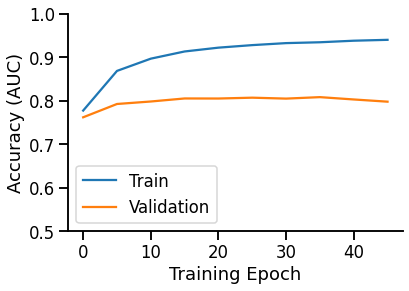

In [186]:
seaborn.set_context('talk')
pyplot.figure(figsize=(6,2))
fit_history.set_index("epoch")[["train_auc", "validation_auc"]].rename(columns={"train_auc": "Train", "validation_auc": "Validation"}).plot(kind='line')
seaborn.despine()
pyplot.ylabel("Accuracy (AUC)")
pyplot.xlabel("Training Epoch")
pyplot.ylim(ymin=0.5, ymax=1)

In [145]:
model.network().summary()

Model: "predictor"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
alpha_allele (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
beta_allele (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
alpha_allele_representation (Em (None, 1, 420)       73500       alpha_allele[0][0]               
__________________________________________________________________________________________________
beta_allele_representation (Emb (None, 1, 462)       571494      beta_allele[0][0]                
__________________________________________________________________________________________

In [185]:
fit_history.sort_values("validation_auc")

,epoch,train_auc,validation_auc,validation_max_peptide_std
0,0,0.777609,0.762153,0.086546
1,5,0.868811,0.792750,0.360440
9,45,0.940279,0.798074,0.695969
2,10,0.896990,0.798479,0.523633
8,40,0.938256,0.803146,0.694374
6,30,0.932729,0.805126,0.680350
4,20,0.922301,0.805316,0.655219
3,15,0.913519,0.805457,0.605702
5,25,0.928124,0.807258,0.663158
7,35,0.934686,0.808510,0.698195


In [147]:
use_validation_df["prediction"] = model.predict(
    validation_peptides,
    allele_encoding_pair=validation_allele_encoding_pair)
grouped = use_validation_df.groupby("original_index")[["prediction", "hit"]].max()
auc = sklearn.metrics.roc_auc_score(grouped.hit.values, grouped.prediction.values)
print("Validation AUC: %0.5f" % auc)

Validation AUC: 0.79972


3.4476505649357536e-06

In [156]:
# Visualization of motifs
peptide_length = 9
all_proteome_peptides = set()
for seq in tqdm.tqdm(proteins_df.sequence.values):
    for i in range(len(seq) - peptide_length):
        all_proteome_peptides.add(seq[i : i + peptide_length])

all_proteome_peptides = pandas.Series(sorted(all_proteome_peptides))
all_proteome_peptides = all_proteome_peptides[all_proteome_peptides.str.match(aa_regex)]
all_proteome_peptides = all_proteome_peptides.sample(frac=0.1)
        
proteome_predictions_df = pandas.DataFrame(index=all_proteome_peptides.values).sample(frac=0.1)
proteome_predictions_df



  0%|          | 0/77156 [00:00<?, ?it/s]

  1%|          | 789/77156 [00:00<00:09, 7859.74it/s]

  2%|▏         | 1484/77156 [00:00<00:10, 7560.05it/s]

  3%|▎         | 2380/77156 [00:00<00:09, 7931.43it/s]

  4%|▍         | 3087/77156 [00:00<00:09, 7648.42it/s]

  5%|▌         | 4005/77156 [00:00<00:09, 8047.38it/s]

  7%|▋         | 5099/77156 [00:00<00:08, 8735.87it/s]

  8%|▊         | 5905/77156 [00:00<00:09, 7742.36it/s]

  9%|▊         | 6653/77156 [00:00<00:10, 6606.99it/s]

  9%|▉         | 7324/77156 [00:00<00:10, 6544.35it/s]

 10%|█         | 7986/77156 [00:01<00:10, 6442.42it/s]

 11%|█         | 8671/77156 [00:01<00:10, 6559.34it/s]

 12%|█▏        | 9332/77156 [00:01<00:10, 6378.41it/s]

 13%|█▎        | 9974/77156 [00:01<00:12, 5198.77it/s]

 14%|█▎        | 10564/77156 [00:01<00:12, 5388.18it/s]

 15%|█▍        | 11237/77156 [00:01<00:11, 5730.45it/s]

 15%|█▌        | 11954/77156 [00:01<00:10, 6097.16it/s]

 16%|█▋        | 12605/77156 [00:01<00:11, 5803.97it/s]



""
INTGSVMVK
SSECSDGEW
WYVRFGELE
NSVKTTLSE
IFLPLLTEF
...
KRKTLTETI
TCRVAGNPK
CYLAACQKR
HGRIYCKPH


In [157]:
# Do predictions for motif visualization

alleles_of_interest = list(train_df.allele.unique())
alleles_of_interest

proteome_peptides = mhc2flurry.encodable_sequences.EncodableSequences.create(proteome_predictions_df.index)
for allele in tqdm.tqdm(alleles_of_interest):
    parsed = mhcgnomes.parse(allele)
    
    proteome_predictions_df[allele] = model.predict(
        proteome_peptides,
        allele_encoding_pair=mhc2flurry.allele_encoding_pair.AlleleEncodingPair(
            mhc2flurry.allele_encoding.AlleleEncoding(
                [parsed.alpha.to_string()] * len(proteome_predictions_df),
                allele_to_sequence=allele_sequences_alpha.to_dict()),
            mhc2flurry.allele_encoding.AlleleEncoding(
                [parsed.beta.to_string()] * len(proteome_predictions_df),
                allele_to_sequence=allele_sequences_beta.to_dict())))
proteome_predictions_df    
    
        



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:01<00:13,  1.54s/it]

 20%|██        | 2/10 [00:01<00:09,  1.19s/it]

 30%|███       | 3/10 [00:02<00:06,  1.05it/s]

 40%|████      | 4/10 [00:02<00:04,  1.26it/s]

 50%|█████     | 5/10 [00:03<00:03,  1.43it/s]

 60%|██████    | 6/10 [00:03<00:02,  1.59it/s]

 70%|███████   | 7/10 [00:04<00:01,  1.72it/s]

 80%|████████  | 8/10 [00:04<00:01,  1.84it/s]

 90%|█████████ | 9/10 [00:05<00:00,  1.91it/s]

100%|██████████| 10/10 [00:05<00:00,  1.98it/s]

,HLA-DRA*01:01-DRB1*12:01,HLA-DRA*01:01-DRB3*01:01,HLA-DPA1*01:03-DPB1*06:01,HLA-DQA1*01:02-DQB1*06:04,HLA-DRA*01:01-DRB1*01:01,HLA-DRA*01:01-DRB1*03:01,HLA-DRA*01:01-DRB1*04:01,HLA-DRA*01:01-DRB1*07:01,HLA-DRA*01:01-DRB1*11:01,HLA-DRA*01:01-DRB1*15:01
INTGSVMVK,0.475903,0.172206,0.105245,0.621744,0.646295,0.134925,0.580272,0.706599,0.157803,0.549076
SSECSDGEW,0.000529,0.000189,0.000699,0.005009,0.000972,0.000172,0.001396,0.000677,0.002183,0.000139
WYVRFGELE,0.767896,0.496524,0.352335,0.984180,0.611377,0.406898,0.755714,0.716461,0.706953,0.415697
NSVKTTLSE,0.060658,0.022866,0.040877,0.002309,0.297781,0.059405,0.230128,0.188952,0.079409,0.231588
IFLPLLTEF,0.142830,0.004431,0.019551,0.005288,0.023425,0.003770,0.045507,0.002609,0.071797,0.016535
...,...,...,...,...,...,...,...,...,...,...
KRKTLTETI,0.009058,0.004367,0.011481,0.005228,0.006146,0.003634,0.018518,0.001541,0.003807,0.006033
TCRVAGNPK,0.022703,0.012687,0.002105,0.005142,0.006630,0.080249,0.005630,0.003199,0.045778,0.009731
CYLAACQKR,0.029025,0.001106,0.000005,0.000024,0.014042,0.006363,0.004689,0.002260,0.150213,0.009858
HGRIYCKPH,0.048365,0.009983,0.043900,0.000515,0.088625,0.025206,0.022046,0.007511,0.101252,0.049036


<Figure size 1440x1152 with 0 Axes>

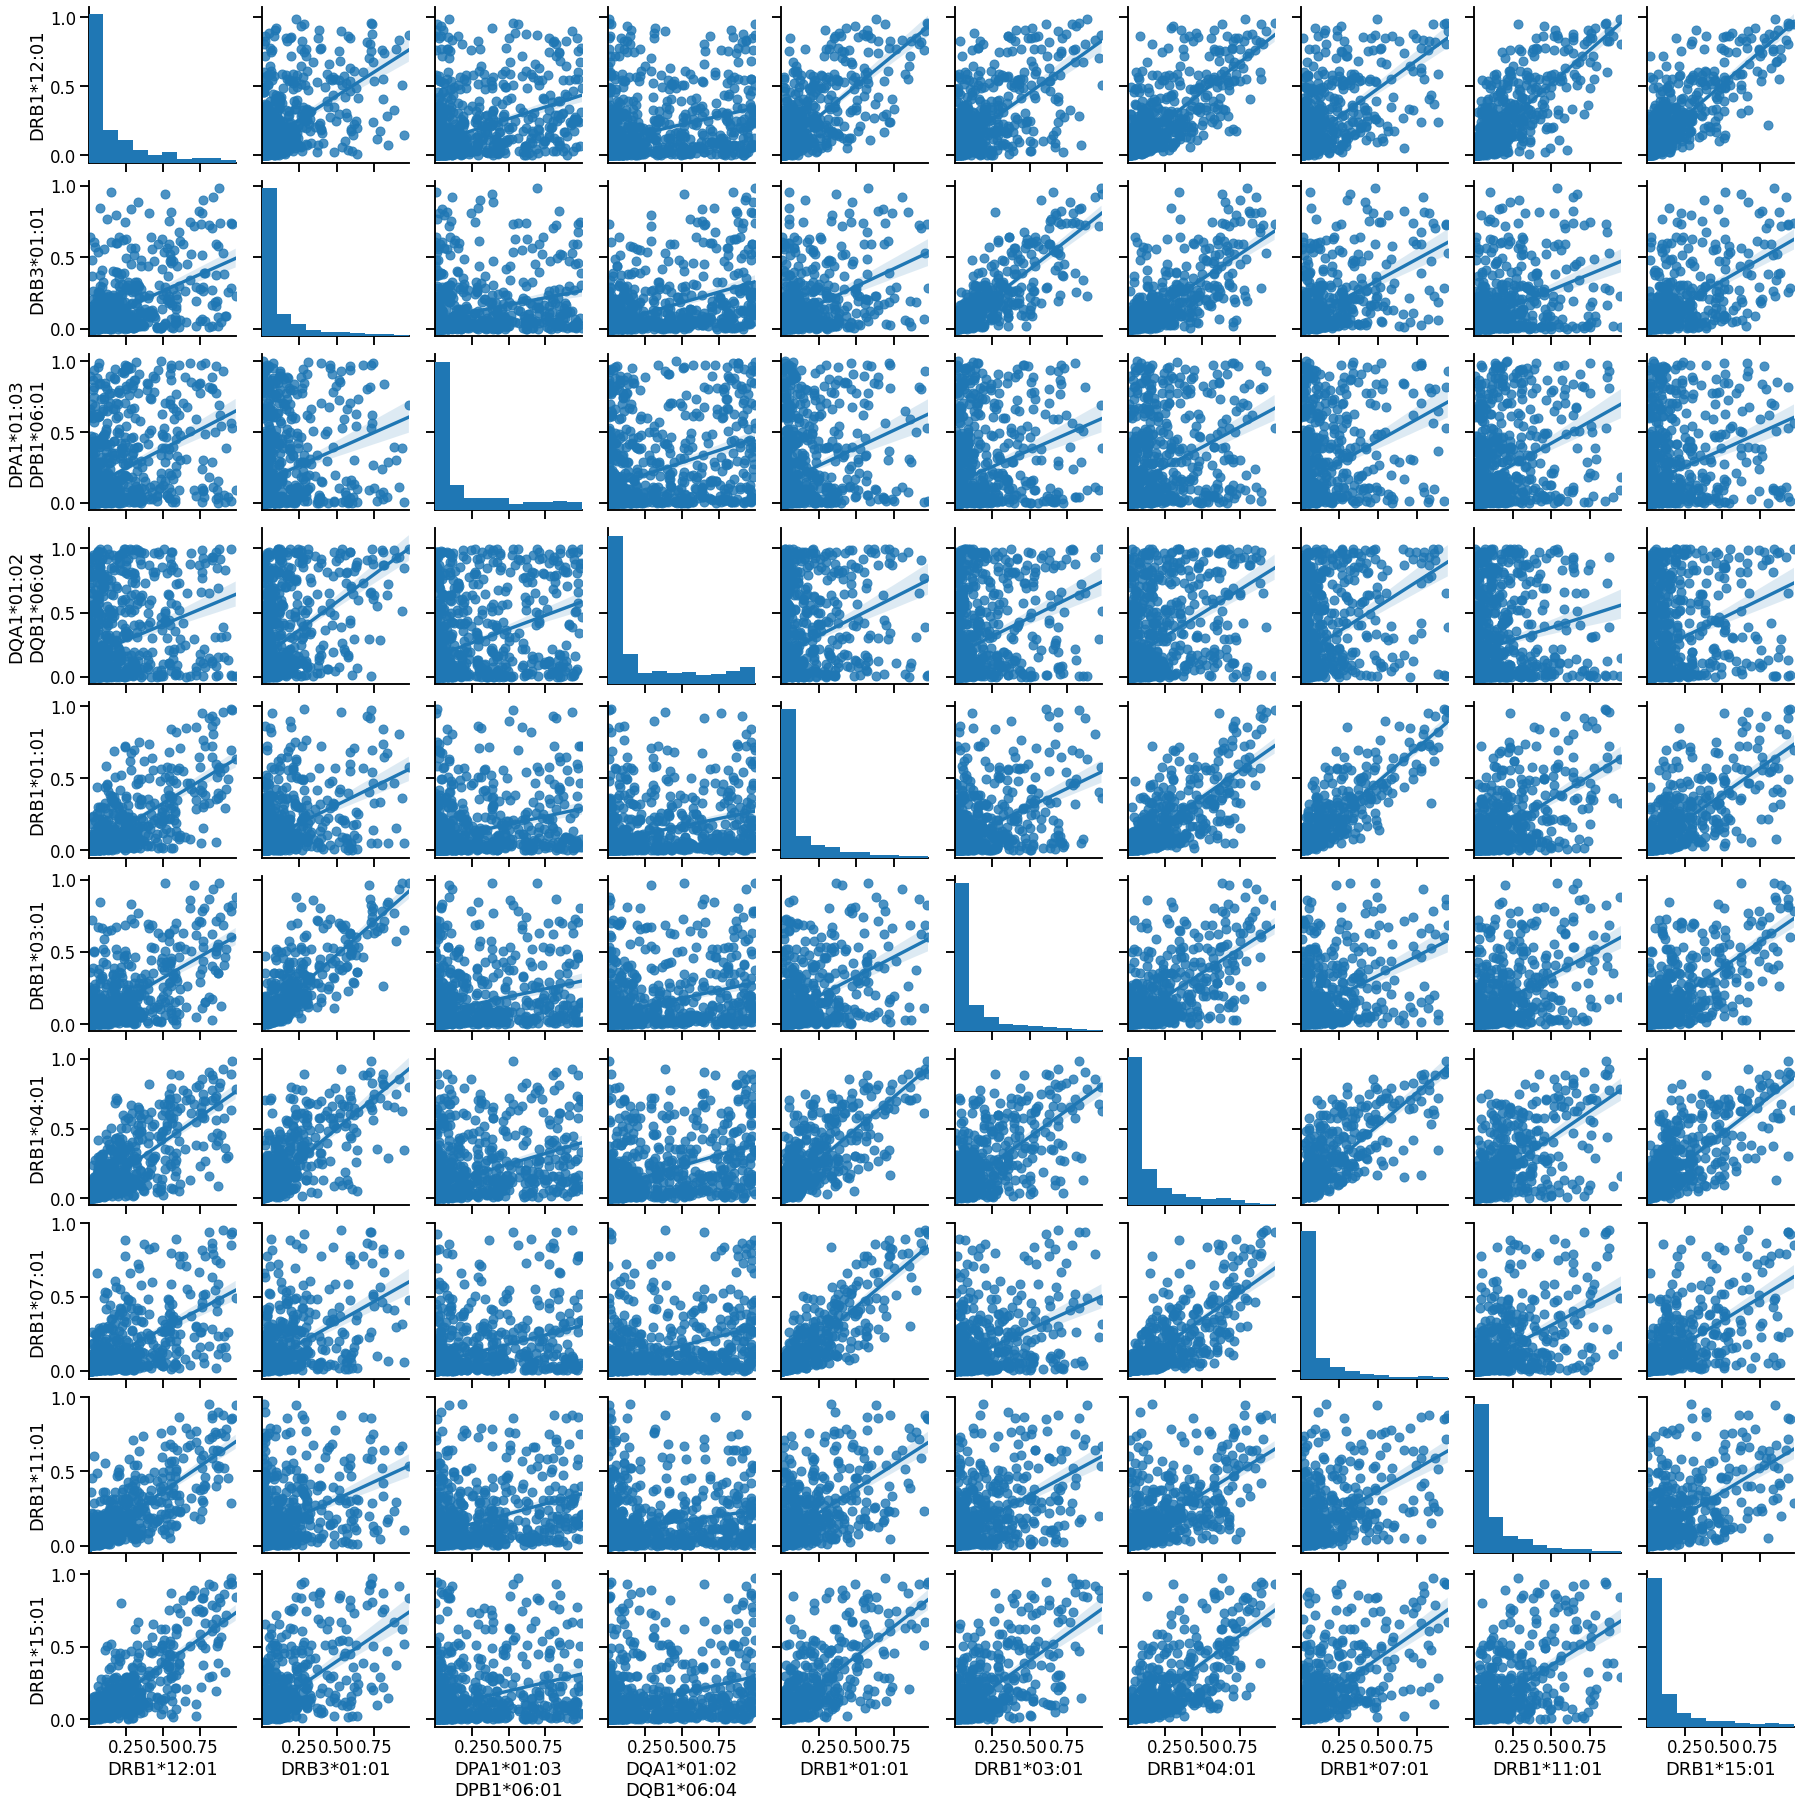

In [184]:
plot_df = proteome_predictions_df.sample(frac=0.01)
plot_df.columns = plot_df.columns.str.replace("HLA-", "").str.replace("DRA*01:01-", "", regex=False).str.replace("-", "\n")

seaborn.set_context('talk')
pyplot.figure(figsize=(20,16))
seaborn.pairplot(plot_df, kind='reg')

In [159]:
%time background_counts = logomaker.alignment_to_matrix(proteome_predictions_df.index.to_series().sample(frac=0.1))
background_counts

CPU times: user 95.2 ms, sys: 45.8 ms, total: 141 ms
Wall time: 145 ms


,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
pos,,,,,,,,,,,,,,,,,,,,
0,594.0,185.0,395.0,679.0,316.0,540.0,215.0,360.0,473.0,829.0,210.0,310.0,590.0,440.0,528.0,730.0,500.0,498.0,137.0,216.0
1,651.0,232.0,386.0,619.0,301.0,598.0,214.0,365.0,497.0,952.0,173.0,280.0,558.0,426.0,480.0,727.0,443.0,504.0,113.0,226.0
2,613.0,206.0,410.0,627.0,308.0,571.0,226.0,356.0,516.0,871.0,160.0,310.0,565.0,435.0,490.0,778.0,486.0,495.0,111.0,211.0
3,592.0,186.0,378.0,601.0,293.0,555.0,253.0,417.0,501.0,865.0,166.0,309.0,563.0,430.0,530.0,784.0,510.0,476.0,120.0,216.0
4,567.0,213.0,401.0,644.0,339.0,569.0,227.0,379.0,484.0,866.0,159.0,314.0,588.0,433.0,468.0,750.0,443.0,533.0,129.0,239.0
5,630.0,198.0,405.0,633.0,323.0,578.0,225.0,353.0,510.0,862.0,161.0,284.0,598.0,448.0,526.0,740.0,459.0,474.0,115.0,223.0
6,604.0,186.0,418.0,616.0,339.0,602.0,211.0,361.0,465.0,847.0,166.0,319.0,581.0,418.0,509.0,737.0,492.0,533.0,119.0,222.0
7,609.0,219.0,420.0,596.0,339.0,605.0,214.0,364.0,505.0,858.0,181.0,315.0,603.0,417.0,479.0,744.0,462.0,496.0,120.0,199.0
8,622.0,206.0,414.0,615.0,306.0,630.0,225.0,370.0,499.0,875.0,162.0,329.0,528.0,415.0,516.0,724.0,459.0,517.0,115.0,218.0


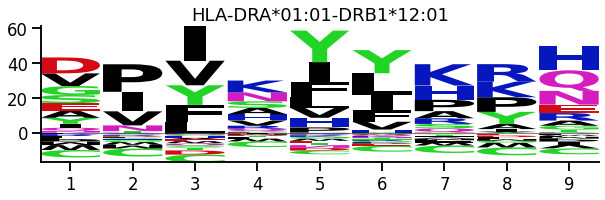

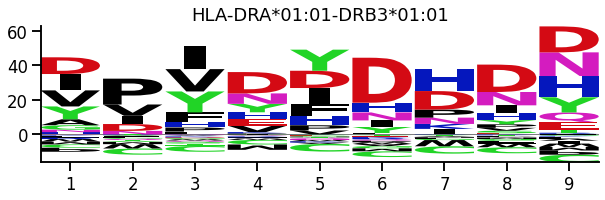

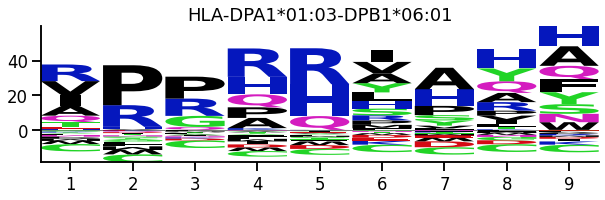

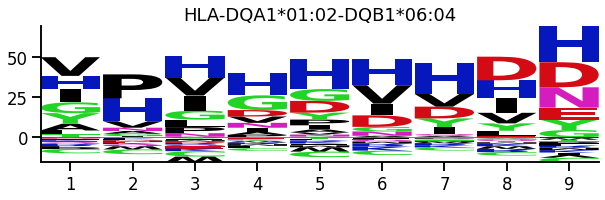

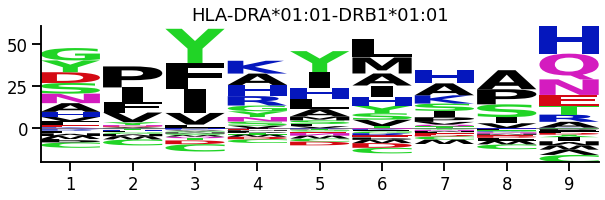

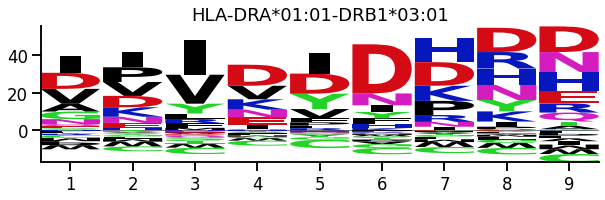

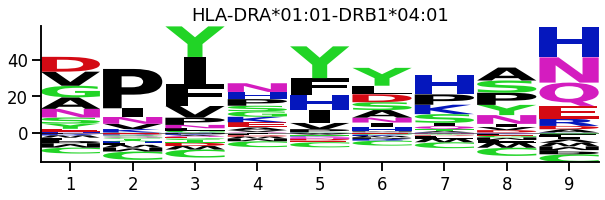

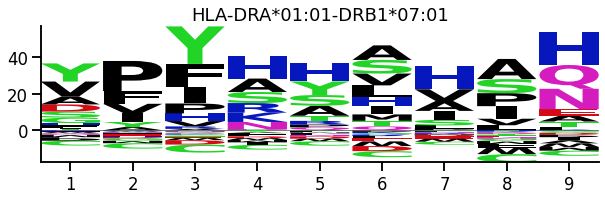

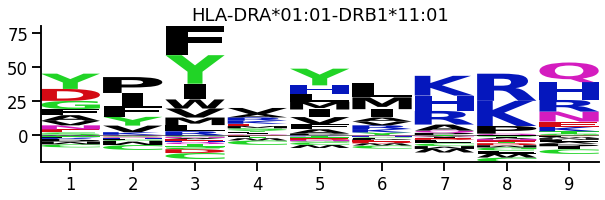

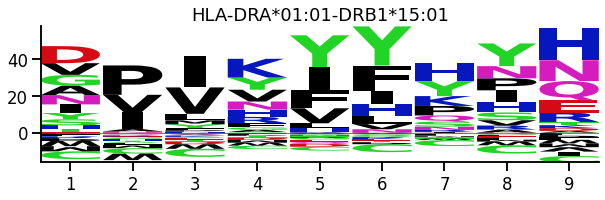

In [183]:
def make_logo(allele):
    top_peptides = proteome_predictions_df[allele].nlargest(int(len(proteome_predictions_df) * 0.01))
    top_peptide_counts = logomaker.alignment_to_matrix(top_peptides.index.to_series())
    pwm = logomaker.transform_matrix(
        top_peptide_counts,
        background=background_counts,
        from_type='counts',
        to_type='weight')
    pwm.index += 1
    adjusted_pwm = pwm.applymap(lambda value: value if value < 0 else value * 10)
    
    logomaker.Logo(adjusted_pwm)
    pyplot.title(allele)
    seaborn.despine()

for allele in proteome_predictions_df.columns:
    make_logo(allele)

,0
HLA-DRA*01:01-DRB1*12:01,HLA-DRA*01:01-DRB1*12:01
HLA-DRA*01:01-DRB3*01:01,HLA-DRA*01:01-DRB3*01:01
HLA-DPA1*01:03-DPB1*06:01,HLA-DPA1*01:03-DPB1*06:01
HLA-DQA1*01:02-DQB1*06:04,HLA-DQA1*01:02-DQB1*06:04
HLA-DRA*01:01-DRB1*01:01,HLA-DRA*01:01-DRB1*01:01
HLA-DRA*01:01-DRB1*03:01,HLA-DRA*01:01-DRB1*03:01
HLA-DRA*01:01-DRB1*04:01,HLA-DRA*01:01-DRB1*04:01
HLA-DRA*01:01-DRB1*07:01,HLA-DRA*01:01-DRB1*07:01
HLA-DRA*01:01-DRB1*11:01,HLA-DRA*01:01-DRB1*11:01
HLA-DRA*01:01-DRB1*15:01,HLA-DRA*01:01-DRB1*15:01


In [161]:
top_peptide_counts.shape

(9, 20)

In [162]:
# Next step:
# - Make a sequence logo of learned motifs
# - Look at accuracy on individual alleles

In [163]:
"""
scores_df = []
to_score = validation_df.copy()
for allele, sub_validation_df in validation_df.groupby("hla"):
    to_score["hit"] = 0
    to_score.loc[sub_validation_df.index, "hit"] = 1
    scores_df.append((
        allele,
        sklearn.metrics.roc_auc_score(to_score.hit, -1 * to_score.prediction),
    ))

scores_df = pandas.DataFrame(scores_df, columns=["allele", "auc"])
scores_df = scores_df.sort_values("auc")

seaborn.barplot(data=scores_df, y="allele", x="auc", color='black')
#pyplot.xlim(xmin=0.5)
pyplot.ylabel("Allele")
seaborn.despine()
scores_df
"""

'\nscores_df = []\nto_score = validation_df.copy()\nfor allele, sub_validation_df in validation_df.groupby("hla"):\n    to_score["hit"] = 0\n    to_score.loc[sub_validation_df.index, "hit"] = 1\n    scores_df.append((\n        allele,\n        sklearn.metrics.roc_auc_score(to_score.hit, -1 * to_score.prediction),\n    ))\n\nscores_df = pandas.DataFrame(scores_df, columns=["allele", "auc"])\nscores_df = scores_df.sort_values("auc")\n\nseaborn.barplot(data=scores_df, y="allele", x="auc", color=\'black\')\n#pyplot.xlim(xmin=0.5)\npyplot.ylabel("Allele")\nseaborn.despine()\nscores_df\n'